In [1]:
!pip install langchain langchain_core langchain_groq langchain_community langchain langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.9/143.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 12.2 MB/s eta 0:00:00


In [2]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph , END
from langchain_core.messages import HumanMessage , AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

Defining Agents

In [3]:
class PlannerState(TypedDict):
  messages : Annotated[List[HumanMessage | AIMessage], "the messages in the conversation" ]
  city : str
  interests : List[str]
  itinerary : str


In [ ]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    temperature = 0,
    groq_api_key = "....",
    model_name = "......"
)
result = llm.invoke("What is Multi AI Agent")
result.content

'A Multi-Agent System (MAS) is a system composed of multiple autonomous agents that interact with each other and their environment to achieve a common goal or set of goals. In the context of Artificial Intelligence (AI), a Multi-AI Agent refers to a system that consists of multiple AI agents that work together to solve complex problems, make decisions, or perform tasks.\n\nCharacteristics of Multi-AI Agent Systems:\n\n1. **Autonomy**: Each AI agent has its own autonomy to make decisions and take actions.\n2. **Interactions**: AI agents interact with each other through communication, cooperation, or competition.\n3. **Distributed Problem-Solving**: Multiple AI agents work together to solve a problem or achieve a goal.\n4. **Decentralized Control**: There is no centralized control, and each AI agent makes its own decisions based on local information and interactions with other agents.\n\nTypes of Multi-AI Agent Systems:\n\n1. **Cooperative Multi-Agent Systems**: AI agents work together t

In [5]:
itinerary_Prompt = ChatPromptTemplate.from_messages([
    ("system", "YOu are a helpful travel assistent. Create a day trip itinerary for {city} based on user interests: {interests}. Provide a brief, bulleted itinerary. "),
    ("human", "Create an itinerary for my day trip.")
])

Define Agent Function

In [6]:
def input_city(state: PlannerState) -> PlannerState:
  print("Please enter the city you want to visit for your day trip: ")
  user_message = input("Your Input: ")
  return {
      **state,
      "city": user_message,
      "messages": state['messages'] + [HumanMessage(content=user_message)]
    }

def input_interest(state: PlannerState) -> PlannerState:
  print(f"Please enter your interest for the trip : {state['city']} (comma-seperated):")
  user_message = input("Your Input: ")
  return {
      **state,
      "interests": [interest.strip() for interest in user_message.split(",")],
      "messages": state['messages'] + [HumanMessage(content=user_message)]
  }

def create_itinerary(state: PlannerState) -> PlannerState:
  print(f"Creating a itinerary for {state['city']} based on interest : {', '.join(state['interests'])}")
  response = llm.invoke(itinerary_Prompt.format_messages(city = state['city'], interests = ', '.join(state['interests'])))
  print("\nFinal Itinerary:")
  print(response.content)
  return {
      **state,
      "messages": state['messages'] + [AIMessage(content=response.content)],
      "itinerary": response.content,
  }

Create and Compile the Graph

In [7]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_city", input_city)
workflow.add_node("input_interest", input_interest)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_city")

workflow.add_edge("input_city", "input_interest")
workflow.add_edge("input_interest", "create_itinerary")
workflow.add_edge("create_itinerary", END)

app = workflow.compile()





Display Graph structure


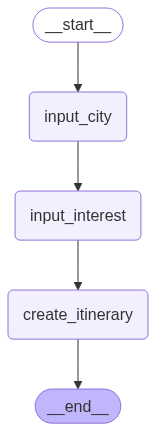

In [8]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method = MermaidDrawMethod.API
        )
    )
)

Defne the function that runs hte graph


In [20]:
def travel_planner(city: str, interests: str):
  print(f"Starting travel planner for city: {city} with interests: {interests}\n")
  # Initialize the state directly with the inputs from Gradio
  initial_state = {
      "messages": [], # Start with an empty message list for the new interaction
      "city": city,
      "interests": [interest.strip() for interest in interests.split(",")],
      "itinerary": "",
  }

  # Since input_city and input_interest nodes are no longer interactive and
  # the state is initialized with city and interests, we can effectively
  # start the graph execution from the create_itinerary node.
  # LangGraph's `stream` method can take a starting node.
  # Alternatively, we can adjust the graph's entry point programmatically or
  # define a conditional edge based on the presence of city/interests in state.

  # For this specific graph structure, directly calling the last relevant node after
  # preparing the state is a simplified approach for this integration example.
  # In a more complex graph, adjusting the entry point or using conditional logic is preferred.

  # Directly call the create_itinerary function with the prepared state
  # This bypasses the input_city and input_interest nodes defined in the graph structure
  final_state = create_itinerary(initial_state)


  return final_state["itinerary"] # Return the generated itinerary

In [10]:
user_request = "I want to plan a day trip"
travel_planner(user_request)

Initial Request: I want to plan a day trip

Please enter the city you want to visit for your day trip: 
Your Input: tokyo
Please enter your interest for the trip : tokyo (comma-seperated):
Your Input: sky tree, sensoji temple
Creating a itinerary for tokyo based on interest : sky tree, sensoji temple

Final Itinerary:
Here's a brief, bulleted itinerary for your day trip to Tokyo based on your interests in Tokyo Skytree and Sensoji Temple:

* 9:00 AM: Start the day at Sensoji Temple in Asakusa, one of the oldest and most iconic temples in Japan. Explore the temple grounds, Nakamise Shopping Street, and try some traditional Japanese snacks.
* 11:30 AM: Walk to the nearby Tokyo Skytree for panoramic views of the city from its observation decks (tickets can be purchased in advance or on-site).
* 1:30 PM: Take a break for lunch at a local restaurant in the Solamachi area, which offers a variety of dining options, from traditional Japanese cuisine to international fare.
* 3:00 PM: Continue e

In [11]:
!pip install gradio

In [23]:
import gradio as gr

iface = gr.Interface(
    fn=travel_planner,
    inputs=[
        gr.Textbox(label="Enter City"),
        gr.Textbox(label="Enter Interests (comma-separated)")
    ],
    outputs="text",
    title="AI-Powered Travel Planner",
    description="Enter a city and your interests to get a personalized day trip itinerary."
)

iface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://52227fcd8f147c03b3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Starting travel planner for city: kolkata with interests: durga puja, kalighat, park street

Creating a itinerary for kolkata based on interest : durga puja, kalighat, park street

Final Itinerary:
Here's a brief, bulleted itinerary for your day trip to Kolkata based on your interests:

* 9:00 AM: Start the day with a visit to **Kalighat Temple**, one of the most famous temples in Kolkata, dedicated to Goddess Kali.
* 11:00 AM: Explore the nearby **Durga Puja pandals** (if you're visiting during the Durga Puja festival) or visit the **Kumortuli Idol Makers' Quarter** to see the artisans at work, creating idols for the festival.
* 1:00 PM: Take a break for lunch at one of the many restaurants on **Park Street**, known for its vibrant atmosphere and diverse dining options.
* 2:30 PM: Spend the afternoon shopping or browsing the street stalls and cafes on **Park Street**, which offers a unique blend of colonial-era architecture and modern charm.
* 5:00 PM: End the day with a visit to the 

In [19]:
def input_city(state: PlannerState) -> PlannerState:
  # This function is modified to not use input() and is likely bypassed when called from Gradio
  # If called, it would expect 'city' to be present in the input state or determined otherwise
  print(f"Processing city: {state.get('city', 'N/A')}")
  # The city should ideally be set before this node in an external interface
  return {
      **state,
      # Assuming city is already in state or handled externally
      "messages": state['messages'] # No new message from interactive input
    }

def input_interest(state: PlannerState) -> PlannerState:
  # This function is modified to not use input() and is likely bypassed when called from Gradio
  # If called, it would expect 'interests' to be present in the input state or determined otherwise
  print(f"Processing interests: {', '.join(state.get('interests', ['N/A']))}")
  # The interests should ideally be set before this node in an external interface
  return {
      **state,
      # Assuming interests are already in state or handled externally
      "messages": state['messages'] # No new message from interactive input
  }


def create_itinerary(state: PlannerState) -> PlannerState:
  print(f"Creating a itinerary for {state.get('city', 'N/A')} based on interest : {', '.join(state.get('interests', ['N/A']))}")
  # Ensure city and interests are available in the state before invoking the LLM
  city = state.get('city')
  interests = state.get('interests')
  if not city or not interests:
      print("City or interests not found in state. Cannot create itinerary.")
      return state # Return current state or handle error as appropriate

  # Format messages for the prompt
  formatted_prompt = itinerary_Prompt.format_messages(city=city, interests=', '.join(interests))

  try:
      response = llm.invoke(formatted_prompt)
      itinerary_content = response.content
      print("\nFinal Itinerary:")
      print(itinerary_content)
      return {
          **state,
          "messages": state['messages'] + [AIMessage(content=itinerary_content)],
          "itinerary": itinerary_content,
      }
  except Exception as e:
      print(f"An error occurred while creating the itinerary: {e}")
      return state # Return current state or handle error as appropriate